# 🧑‍🎓 Students:

- Marwan MASHRA
- Abdurrahman Shahid

# Deep Learning - Lab Exercise 4


In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import sys
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
batch_size = 128   
dim_latent = 2
n_montecarlo = 5   # number of samples for monte-carlo estimation of reconstruction loss

## Loading the data

In [4]:
import dataset_loader

mnist_path = "./mnist.pkl.gz"

# load the 3 splits
train_data_raw, dev_data_raw, test_data_raw = dataset_loader.load_mnist(mnist_path)

def build_torch_inputs(data):
    x, y = data
    ret = list()
    
    for i in range(x.shape[0]):
        input_tensor = torch.from_numpy(x[i]).reshape(1, -1)
        output_value = int(y[i])
        
        ret.append({
            "input_tensor": input_tensor,
            "output_value": output_value
        })
        
    return ret
        
train_data_raw = build_torch_inputs(train_data_raw)
dev_data_raw = build_torch_inputs(dev_data_raw)
test_data_raw = build_torch_inputs(test_data_raw)

## Creating the dataset

In [5]:
class Dataset(torch.utils.data.Dataset):
      'Characterizes a dataset for PyTorch'
      def __init__(self, data):
            'Initialization'
            self.data = data

      def __len__(self):
            'Denotes the total number of samples'
            return len(self.data)

      def __getitem__(self, index):
            'Generates one sample of data'
            # Select sample
            data_point = self.data[index]
            X = data_point['input_tensor'][0]
            y = data_point['output_value']

            return X, y

train_data = torch.utils.data.DataLoader(
            Dataset(train_data_raw),
            batch_size=batch_size,
            shuffle=True)
dev_data = torch.utils.data.DataLoader(
            Dataset(dev_data_raw),
            batch_size=batch_size,
            shuffle=True)
test_data = torch.utils.data.DataLoader(
            Dataset(test_data_raw),
            batch_size=batch_size,
            shuffle=True)

## Building the VAE

In [6]:
class VAEEncoder(nn.Module):
    def __init__(self, dim_input, dim_latent):
        super().__init__()
        self.dim_input = dim_input
        self.dim_latent = dim_latent

        self.linear1 = nn.Linear(self.dim_input, 512)
        self.linear2 = nn.Linear(512, self.dim_latent)
        self.linear3 = nn.Linear(512, self.dim_latent)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        log_sigma_squared = self.linear3(x)
        return mu, log_sigma_squared

In [7]:
class VAEDecoder(nn.Module):
    def __init__(self, dim_input, dim_latent):
        super().__init__()
        self.dim_input = dim_input
        self.dim_latent = dim_latent

        self.linear1 = nn.Linear(self.dim_latent, 512)
        self.linear2 = nn.Linear(512, self.dim_input)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, self.dim_input))

In [8]:
class VAE(nn.Module):
    def __init__(self, dim_input, dim_latent):
        super().__init__()
        self.encoder = VAEEncoder(dim_input, dim_latent)
        self.decoder = VAEDecoder(dim_input, dim_latent)

    def forward(self, x):
        mu, log_sigma_squared = self.encoder(x)
        e = torch.normal(0, 1., mu.shape).to(device) # GPU
        z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))
        self.kl = -0.5 * torch.mean(torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp(), dim=1))
        return self.decoder(z)

## Training

In [9]:
def train(vae, data, n_epochs, grad_clip_value=None, grad_clip_norm=None, lr=1e-3, momentum=0.9):
    opt = torch.optim.SGD(vae.parameters(), lr=lr, momentum=momentum)
    history = {
        'loss':[],
        'mu':[],
        'log_sigma_squared':[]
    }
    for epoch in range(n_epochs):
        x = None
        loss = 0 
        for _x, y in data:
            x = _x.to(device) # GPU
            opt.zero_grad()

            # monte carlo estimation of the reconstruction loss
            reconstruction_loss = 0
            for _ in range(n_montecarlo):
                x_hat = vae(x)
                reconstruction_loss += torch.mean(torch.sum((x-x_hat)**2,dim=1))/n_montecarlo

            loss = reconstruction_loss + vae.kl
            print(f'Epoch:{epoch+1}/{n_epochs} loss:{loss:.4g}', end='\r')
            sys.stdout.flush()
            
            loss.backward()
            if grad_clip_value is not None:
                torch.nn.utils.clip_grad_value_(parameters=vae.parameters(), clip_value=grad_clip_value)  # clip_value to be fine-tuned
            if grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(parameters=vae.parameters(), max_norm=grad_clip_norm)    # clip by norm
            opt.step()

        # keep the history of the training
        mu, log_sigma_squared = vae.encoder(x)
        history['mu'].append(mu)
        history['log_sigma_squared'].append(log_sigma_squared)
        history['loss'].append(loss)

    return vae, history

In [13]:
dim_input = train_data.dataset[0][0].shape[0]
vae = VAE(dim_input, dim_latent).to(device) # GPU
vae, results = train(vae, train_data, n_epochs=5, grad_clip_value=.3)

## Experiments

In [18]:
history = {}
n_epochs = 10

### gradient clipping values

In [19]:
grad_clip_values = [.1, .3, .5, 1, 2, 5]
history['grad_clip_values'] = {'values':grad_clip_values, 'results':[]}
for i, grad_clip_value in enumerate(grad_clip_values):
    print(f'Experiment {i+1}/{len(grad_clip_values)}')
    vae = VAE(dim_input, dim_latent).to(device) # GPU
    vae, results = train(vae, train_data, n_epochs=n_epochs, grad_clip_value=grad_clip_value)
    history['grad_clip_values']['results'].append(results)

Experiment 1/6
Experiment 2/6ss:42.71
Experiment 3/6ss:43.17
Experiment 4/6ss:41.93
Experiment 5/6ss:41.35
Experiment 6/6ss:41.47


### gradient clipping norms

In [20]:
grad_clip_norms = [.1, .3, .5, 1, 2, 5]
history['grad_clip_norms'] = {'values':grad_clip_norms, 'results':[]}
for i, grad_clip_norm in enumerate(grad_clip_norms):
    print(f'Experiment {i+1}/{len(grad_clip_norms)}')
    vae = VAE(dim_input, dim_latent).to(device) # GPU
    vae, results = train(vae, train_data, n_epochs=n_epochs, grad_clip_norm=grad_clip_norm)
    history['grad_clip_norms']['results'].append(results)

Experiment 1/6
Experiment 2/6ss:65.02
Experiment 3/6ss:50.78
Experiment 4/6ss:49.82
Experiment 5/6ss:47.12
Experiment 6/6ss:42.01


### momentum

In [25]:
momentums = [1,.95,.9,.85,.8,.7,.6]
history['momentums'] = {'values':momentums, 'results':[]}
for i, momentum in enumerate(momentums):
    print(f'Experiment {i+1}/{len(momentums)}')
    vae = VAE(dim_input, dim_latent).to(device) # GPU
    vae, results = train(vae, train_data, n_epochs=n_epochs, momentum=momentum)
    history['momentums']['results'].append(results)

Experiment 1/7
Experiment 2/7ss:55.67
Experiment 3/7ss:41.56
Experiment 4/7ss:41.76
Experiment 5/7ss:40.77
Experiment 6/7ss:42.36
Experiment 7/7ss:43.36


### Save the history

In [22]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history, f)

## Results analysis

### Load the history

In [12]:
with open('history.pkl', 'rb') as f:
    history = pickle.load(f)

history.keys()

dict_keys(['grad_clip_values', 'grad_clip_norms', 'momentums'])

### gradient clipping values

In [187]:
values = history['grad_clip_values']['values']
mu1 = []
mu2 = []
log_sigma_squared1 = []
log_sigma_squared2 = []
loss = []
for result in history['grad_clip_values']['results']:
    mu = torch.mean(result['mu'][-1], dim=0).cpu().detach().numpy()
    mu1.append(mu[0])
    mu2.append(mu[1])
    log_sigma_squared = torch.mean(result['log_sigma_squared'][-1], dim=0).cpu().detach().numpy()
    log_sigma_squared1.append(log_sigma_squared[0])
    log_sigma_squared2.append(log_sigma_squared[1])
    loss.append(result['loss'][-1].cpu().detach().numpy())

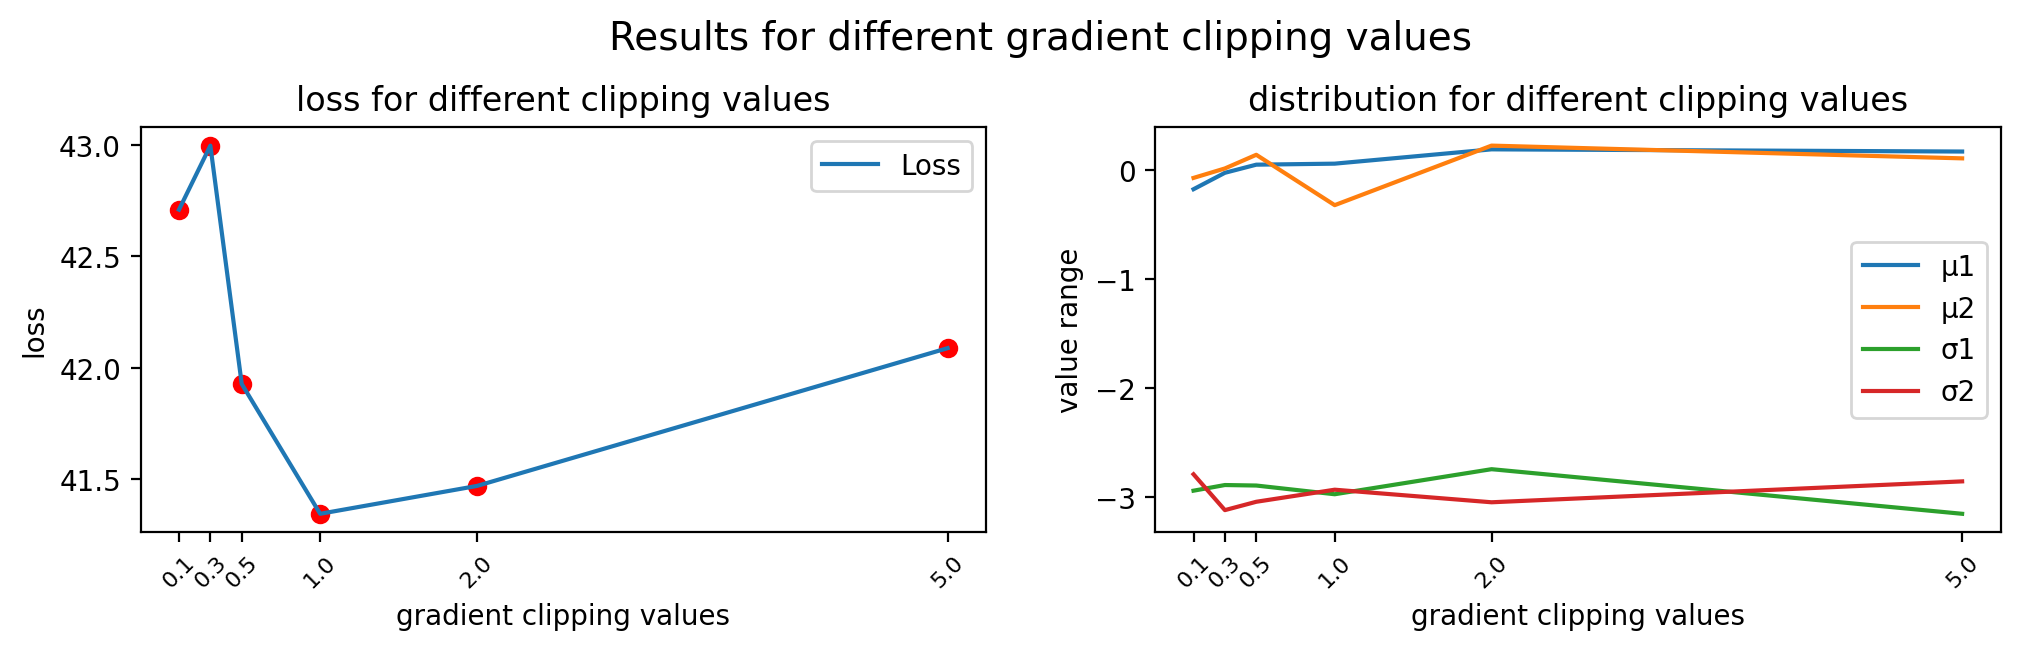

In [188]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(values,loss, label='Loss')
ax[1].plot(values,mu1, label='μ1')
ax[1].plot(values,mu2, label='μ2')
ax[1].plot(values,log_sigma_squared1, label='σ1')
ax[1].plot(values,log_sigma_squared2, label='σ2')

ax[0].set_xlabel("gradient clipping values")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[0].scatter(values, loss, c='r')

ax[1].set_xlabel("gradient clipping values")
ax[1].set_ylabel("value range")
ax[1].legend(loc=5)
ax[0].set_title(f"loss for different clipping values", size=12)
ax[1].set_title(f"distribution for different clipping values", size=12)
ax[0].tick_params(axis='x', which='major', labelsize=8, rotation=45)
ax[1].tick_params(axis='x', which='major', labelsize=8, rotation=45)

ax[0].set_xticks(values)
ax[1].set_xticks(values)
fig.suptitle(f"Results for different gradient clipping values", size=14)
fig.subplots_adjust(top=0.8);

### gradient clipping norms

In [185]:
values = history['grad_clip_norms']['values']
mu1 = []
mu2 = []
log_sigma_squared1 = []
log_sigma_squared2 = []
loss = []
for result in history['grad_clip_norms']['results']:
    mu = torch.mean(result['mu'][-1], dim=0).cpu().detach().numpy()
    mu1.append(mu[0])
    mu2.append(mu[1])
    log_sigma_squared = torch.mean(result['log_sigma_squared'][-1], dim=0).cpu().detach().numpy()
    log_sigma_squared1.append(log_sigma_squared[0])
    log_sigma_squared2.append(log_sigma_squared[1])
    loss.append(result['loss'][-1].cpu().detach().numpy())

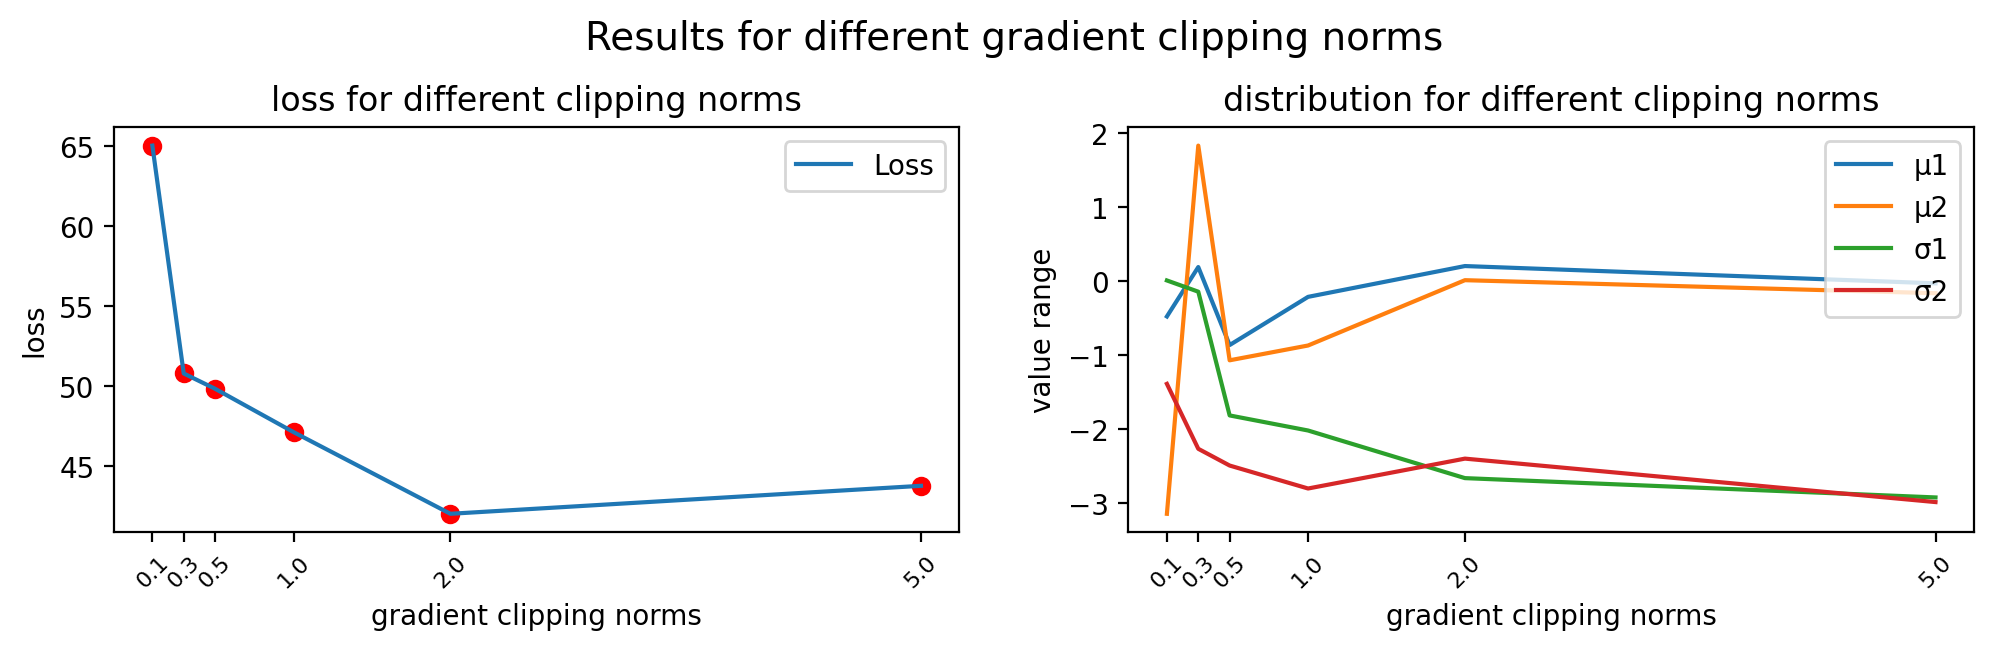

In [186]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(values,loss, label='Loss')
ax[1].plot(values,mu1, label='μ1')
ax[1].plot(values,mu2, label='μ2')
ax[1].plot(values,log_sigma_squared1, label='σ1')
ax[1].plot(values,log_sigma_squared2, label='σ2')

ax[0].set_xlabel("gradient clipping norms")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[0].scatter(values, loss, c='r')

ax[1].set_xlabel("gradient clipping norms")
ax[1].set_ylabel("value range")
ax[1].legend(loc=1)
ax[0].set_title(f"loss for different clipping norms", size=12)
ax[1].set_title(f"distribution for different clipping norms", size=12)
ax[0].tick_params(axis='x', which='major', labelsize=8, rotation=45)
ax[1].tick_params(axis='x', which='major', labelsize=8, rotation=45)
ax[0].set_xticks(values)
ax[1].set_xticks(values)
fig.suptitle(f"Results for different gradient clipping norms", size=14)
fig.subplots_adjust(top=0.8);

### momentum

In [189]:
values = history['momentums']['values']
mu1 = []
mu2 = []
log_sigma_squared1 = []
log_sigma_squared2 = []
loss = []
for result in history['momentums']['results']:
    mu = torch.mean(result['mu'][-1], dim=0).cpu().detach().numpy()
    mu1.append(mu[0])
    mu2.append(mu[1])
    log_sigma_squared = torch.mean(result['log_sigma_squared'][-1], dim=0).cpu().detach().numpy()
    log_sigma_squared1.append(log_sigma_squared[0])
    log_sigma_squared2.append(log_sigma_squared[1])
    loss.append(result['loss'][-1].cpu().detach().numpy())

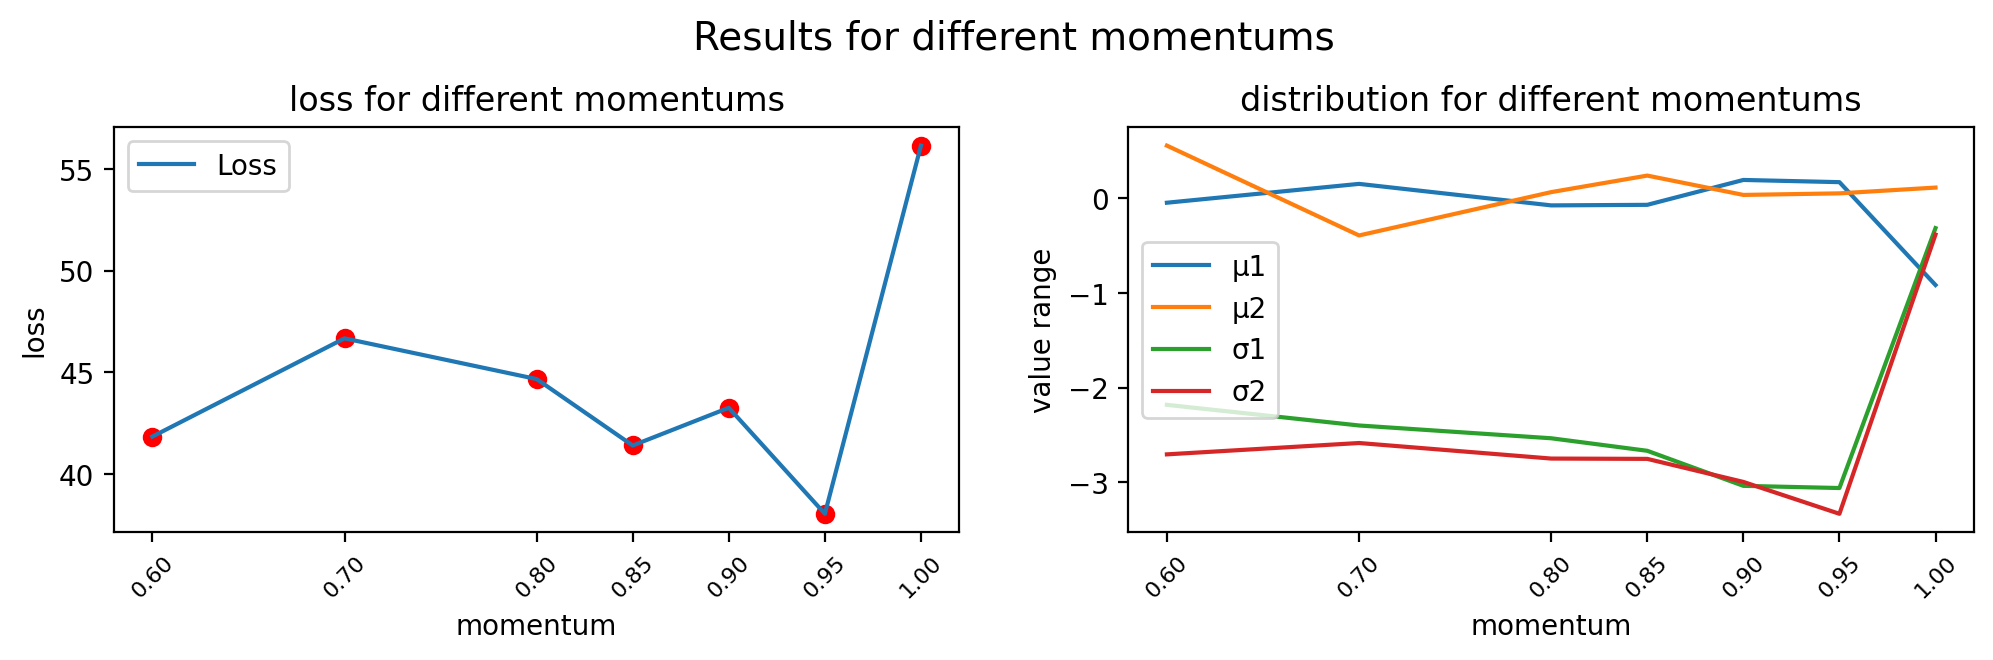

In [193]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(values,loss, label='Loss')
ax[1].plot(values,mu1, label='μ1')
ax[1].plot(values,mu2, label='μ2')
ax[1].plot(values,log_sigma_squared1, label='σ1')
ax[1].plot(values,log_sigma_squared2, label='σ2')

ax[0].set_xlabel("momentum")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[0].scatter(values, loss, c='r')

ax[1].set_xlabel("momentum")
ax[1].set_ylabel("value range")
ax[1].legend(loc=6)
ax[0].set_title(f"loss for different momentums", size=12)
ax[1].set_title(f"distribution for different momentums", size=12)
ax[0].tick_params(axis='x', which='major', labelsize=8, rotation=45)
ax[1].tick_params(axis='x', which='major', labelsize=8, rotation=45)
ax[0].set_xticks(values)
ax[1].set_xticks(values)
fig.suptitle(f"Results for different momentums", size=14)
fig.subplots_adjust(top=0.8);

## Best Model

In [209]:
dim_input = train_data.dataset[0][0].shape[0]
vae = VAE(dim_input, dim_latent).to(device) # GPU
vae, results = train(vae, train_data, n_epochs=10, grad_clip_value=1, momentum=.9)

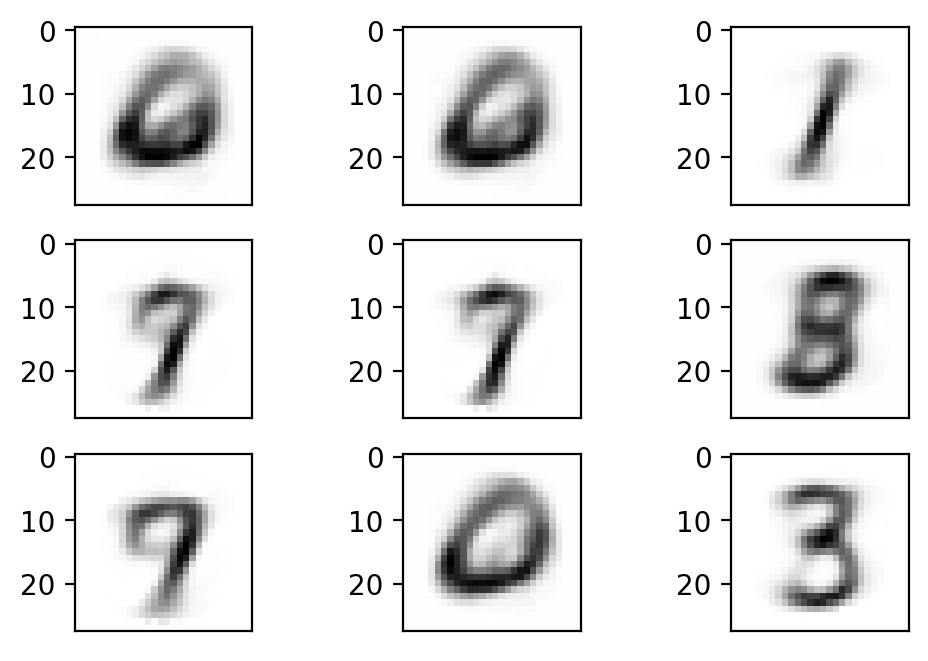

In [237]:
e = torch.normal(.1, 1., (10, 2)).to(device)
images = vae.decoder(e)

fig, ax = plt.subplots(nrows=3, ncols=3)
k = 0
for i in range(3):
    for j in range(3):
        picture = images[k].to('cpu').clone().detach().numpy()
        k += 1
        ax[i,j].imshow(picture.reshape(28,28), cmap='Greys')
        ax[i,j].get_xaxis().set_ticks([])